In [1]:
# Седьмая нейросеть. Передача обучения

# Установка TensorFlowHub
!pip install tensorflow_hub

# Импорт библиотек
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import numpy as np
import PIL.Image as Image
import os

In [2]:
# Загрузка обученного вектора признаков (классификатора)
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMAGE_RES = 224 # MobileNet на входе получает изображения 224х224х3

# Создание модели
model = tf.keras.Sequential([
     hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3)) # Использование вектора признаков как слоя
])

65536/61306 [================================] - 0s 0us/step


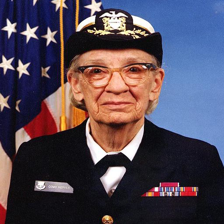

In [3]:
# MobileNet была обучена на датасете ImageNet, который содержит 1000 выходных классов
# Надо найти один из классов вне ImageNet для проверки точности классификации
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES)) # Изменение размера изображения
grace_hopper # Выведет изображение

In [4]:
# Предсказания
grace_hope = np.array(grace_hopper)/255.0 # Преобразование в массив и приведение к диапазону [0,1]
print(grace_hope.shape) # Вывод информации о количестве блоков массива
result = model.predict(grace_hope[np.newaxis, ...]) # Предсказание
print(result.shape) # Вывод информации о количестве блоков предсказания
predicted_class = np.argmax(result[0], axis=-1) # Позиция максимального значения вероятности в массиве
print(predicted_class) # Вывод позиции

(224, 224, 3)
(1, 1001)
653


16384/10484 [==============================================] - 0s 0us/step


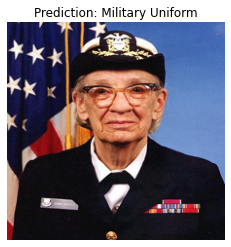

In [5]:
# Расшифровка предсказаний
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines()) # Получение меток ImageNet
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [6]:
# Создание переменных путей к датасету с кошками и собаками
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)
zip_dir_base = os.path.dirname(zip_dir)
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))
total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

# Функция, которая возвращает изображения со случайными преобразованиями
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# Удаление модели и количество изображения для тренировки перед обновлением данных
BATCH_SIZE = 32
del model

# Создаём генераторы
train_image_generator = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                           height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                           horizontal_flip=True, fill_mode='nearest')
validation_image_generator = ImageDataGenerator(rescale=1./255)

# Загрузка тренировочных данных
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(IMAGE_RES,IMAGE_RES),
                                                          class_mode='binary')

# Затем валидационные данные
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMAGE_RES,IMAGE_RES),
                                                              class_mode='binary')

68608000/68606236 [==============================] - 3s 0us/step
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
# Создание словя с использованием MobileNet
feature_extractor = hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
feature_extractor.trainable = False # Заморозка слоя, чтобы его переменные не менялись

# Создание модели
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])

# Вывод информации о модели
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              3540265   
_________________________________________________________________
dense (Dense)                (None, 2)                 2004      
Total params: 3,542,269
Trainable params: 2,004
Non-trainable params: 3,540,265
_________________________________________________________________


In [8]:
EPOCHS = 6 # Количество обучающих прогонов

# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Тренировка модели
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/6
63/63 [==============================] - 28s 451ms/step - loss: 0.2079 - accuracy: 0.9180 - val_loss: 0.0736 - val_accuracy: 0.9780
Epoch 2/6
63/63 [==============================] - 28s 444ms/step - loss: 0.1128 - accuracy: 0.9570 - val_loss: 0.0626 - val_accuracy: 0.9830
Epoch 3/6
63/63 [==============================] - 28s 439ms/step - loss: 0.0877 - accuracy: 0.9675 - val_loss: 0.0605 - val_accuracy: 0.9810
Epoch 4/6
63/63 [==============================] - 28s 441ms/step - loss: 0.0784 - accuracy: 0.9690 - val_loss: 0.0561 - val_accuracy: 0.9850
Epoch 5/6
63/63 [==============================] - 28s 438ms/step - loss: 0.0804 - accuracy: 0.9705 - val_loss: 0.0594 - val_accuracy: 0.9840
Epoch 6/6
63/63 [==============================] - 28s 439ms/step - loss: 0.0799 - accuracy: 0.9730 - val_loss: 0.0594 - val_accuracy: 0.9850


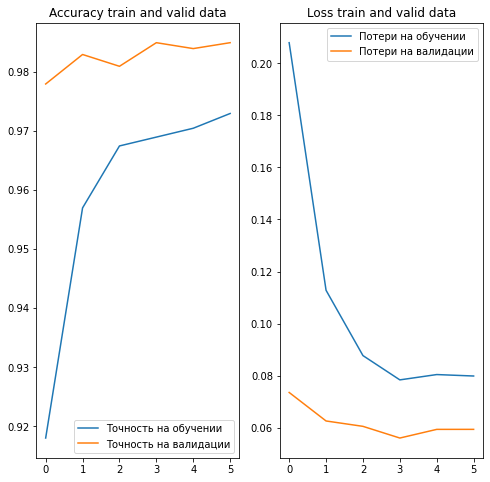

In [9]:
# Визуализация результатов тренировки
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')
plt.title('Accuracy train and valid data')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Loss train and valid data')
plt.show()